In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers
import matplotlib.pyplot as plt 
import seaborn as sns

#https://towardsdatascience.com/the-use-of-knn-for-missing-values-cf33d935c637
#https://gist.github.com/YohanObadia/b310793cd22a4427faaadd9c381a5850

def weighted_hamming(data):
    """ Compute weighted hamming distance on categorical variables. For one variable, it is equal to 1 if
        the values between point A and point B are different, else it is equal the relative frequency of the
        distribution of the value across the variable. For multiple variables, the harmonic mean is computed
        up to a constant factor.
        @params:
            - data = a pandas data frame of categorical variables
        @returns:
            - distance_matrix = a distance matrix with pairwise distance for all attributes
    """
    categories_dist = []
    
    for category in data:
        X = pd.get_dummies(data[category])
        X_mean = X * X.mean()
        X_dot = X_mean.dot(X.transpose())
        X_np = np.asarray(X_dot.replace(0,1,inplace=False))
        categories_dist.append(X_np)
    categories_dist = np.array(categories_dist)
    distances = hmean(categories_dist, axis=0)
    return distances


def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    """ Compute the pairwise distance attribute by attribute in order to account for different variables type:
        - Continuous
        - Categorical
        For ordinal values, provide a numerical representation taking the order into account.
        Categorical variables are transformed into a set of binary ones.
        If both continuous and categorical distance are provided, a Gower-like distance is computed and the numeric
        variables are all normalized in the process.
        If there are missing values, the mean is computed for numerical attributes and the mode for categorical ones.
        
        Note: If weighted-hamming distance is chosen, the computation time increases a lot since it is not coded in C 
        like other distance metrics provided by scipy.
        @params:
            - data                  = pandas dataframe to compute distances on.
            - numeric_distances     = the metric to apply to continuous attributes.
                                      "euclidean" and "cityblock" available.
                                      Default = "euclidean"
            - categorical_distances = the metric to apply to binary attributes.
                                      "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                      available. Default = "jaccard"
        @returns:
            - the distance matrix
    """
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    # Get the type of each attribute (Numeric or categorical)
    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

    # Check the content of the distances parameter
    if numeric_distance not in possible_continuous_distances:
        print("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print ("The binary distance " + categorical_distance + " is not supported.")
        return None

    # Separate the data frame into categorical and numeric attributes and normalize numeric data
    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

    # Replace missing values with column mean for numeric values and mode for categorical ones. With the mode, it
    # triggers a warning: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
    # but the value are properly replaced
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        data.fillna(data.mean(), inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)

    # "Dummifies" categorical variables in place
    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    # Fill the diagonal with NaN values
    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)


def knn_impute(target, attributes, k_neighbors, aggregation_method="mean", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):
    """ Replace the missing values within the target variable based on its k nearest neighbors identified with the
        attributes variables. If more than 50% of its neighbors are also missing values, the value is not modified and
        remains missing. If there is a problem in the parameters provided, returns None.
        If to many neighbors also have missing values, leave the missing value of interest unchanged.
        @params:
            - target                        = a vector of n values with missing values that you want to impute. The length has
                                              to be at least n = 3.
            - attributes                    = a data frame of attributes with n rows to match the target variable
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
            - aggregation_method            = how to aggregate the values from the nearest neighbors (mean, median, mode)
                                              Default = "mean"
            - numeric_distances             = the metric to apply to continuous attributes.
                                              "euclidean" and "cityblock" available.
                                              Default = "euclidean"
            - categorical_distances         = the metric to apply to binary attributes.
                                              "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                              available. Default = "jaccard"
            - missing_neighbors_threshold   = minimum of neighbors among the k ones that are not also missing to infer
                                              the correct value. Default = 0.5
        @returns:
            target_completed        = the vector of target values with missing value replaced. If there is a problem
                                      in the parameters, return None
    """

    # Get useful variables
    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(target)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in target)

    # Check for possible errors
    if number_observations < 3:
        print("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print ("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print ("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print ("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print ("The only method allowed for categorical target variable is the mode.")
        return None

    # Make sure the data are in the right format
    target = pd.DataFrame(target)
    attributes = pd.DataFrame(attributes)

    # Get the distance matrix and check whether no error was triggered when computing it
    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    # Get the closest points and compute the correct aggregation method
    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            # Compute the right aggregation method if at least more than 50% of the closest neighbors are not missing
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                target.iloc[i] = stats.mode(closest_to_target, nan_policy='omit')[0][0]

    return target

In [3]:
data_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/INSIAD_GCD/final_data_set_09082019_1.csv')
del data_df['Unnamed: 0']
data_df.head()

,employee_id,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,113558,111,0,NaN,0.753977,5,1.0,2,0.921208,0,4
1,112256,201,1,NaN,0.964453,3,NaN,2,0.568479,0,3
2,112586,239,2,NaN,0.756458,3,NaN,1,0.144812,0,6
3,108071,151,0,NaN,0.608282,5,NaN,2,0.210300,0,6
4,116915,259,3,NaN,0.749206,4,NaN,2,0.888514,0,3


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14150 entries, 0 to 14149
Data columns (total 11 columns):
employee_id          14150 non-null int64
avg_monthly_hrs      14150 non-null int64
department           14150 non-null int64
filed_complaint      2046 non-null float64
last_evaluation      12663 non-null float64
n_projects           14150 non-null int64
recently_promoted    297 non-null float64
salary               14150 non-null int64
satisfaction         14150 non-null float64
status               14150 non-null int64
tenure               14150 non-null int64
dtypes: float64(4), int64(7)
memory usage: 1.2 MB


In [0]:
#https://medium.com/@yohan.obadia/this-is-a-great-question-83072ef9381c
drop_list=["recently_promoted","filed_complaint","employee_id","status"]
df_frame = knn_impute(target=data_df['recently_promoted'], attributes=data_df.drop(drop_list, 1),
                                    aggregation_method="median", k_neighbors=4, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)
data_df['recently_promoted'] = df_frame['recently_promoted']

In [6]:
sum(pd.isnull(df_frame['recently_promoted']))
df_frame.info()
df_frame['recently_promoted'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14150 entries, 0 to 14149
Data columns (total 1 columns):
recently_promoted    1906 non-null float64
dtypes: float64(1)
memory usage: 110.6 KB


array([ 1., nan])

In [0]:
drop_list=["filed_complaint","recently_promoted","employee_id","status"]
df_frame = knn_impute(target=data_df['filed_complaint'], attributes=data_df.drop(drop_list, 1),
                                    aggregation_method="median", k_neighbors=4, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)
data_df['filed_complaint'] = df_frame['filed_complaint']

In [8]:
sum(pd.isnull(df_frame['filed_complaint']))
df_frame.info()
df_frame['filed_complaint'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14150 entries, 0 to 14149
Data columns (total 1 columns):
filed_complaint    9103 non-null float64
dtypes: float64(1)
memory usage: 110.6 KB


array([nan,  1.])

In [0]:
#drop_list=["last_evaluation","employee_id","status"]
#df_frame = knn_impute(target=data_df['last_evaluation'], attributes=data_df.drop(drop_list, 1),
#                                    aggregation_method="median", k_neighbors=4, numeric_distance='euclidean',
#                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)
#data_df['last_evaluation'] = df_frame['last_evaluation']

In [0]:
#sum(pd.isnull(df_frame['last_evaluation']))
#df_frame.info()
#df_frame['last_evaluation'].unique()

In [11]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14150 entries, 0 to 14149
Data columns (total 11 columns):
employee_id          14150 non-null int64
avg_monthly_hrs      14150 non-null int64
department           14150 non-null int64
filed_complaint      9103 non-null float64
last_evaluation      12663 non-null float64
n_projects           14150 non-null int64
recently_promoted    1906 non-null float64
salary               14150 non-null int64
satisfaction         14150 non-null float64
status               14150 non-null int64
tenure               14150 non-null int64
dtypes: float64(4), int64(7)
memory usage: 1.2 MB


In [0]:
data_df.filed_complaint.fillna(0, inplace = True)
data_df.recently_promoted.fillna(0, inplace = True)
data_df['filed_complaint'] = data_df.filed_complaint.astype(int)
data_df['recently_promoted'] = data_df.recently_promoted.astype(int)

mean_last_evaluation = data_df.last_evaluation.mean()
data_df.last_evaluation.fillna(mean_last_evaluation, inplace = True)

#data_df.to_csv('/content/drive/My Drive/Colab Notebooks/colab_final_data_set.csv')

In [13]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14150 entries, 0 to 14149
Data columns (total 11 columns):
employee_id          14150 non-null int64
avg_monthly_hrs      14150 non-null int64
department           14150 non-null int64
filed_complaint      14150 non-null int64
last_evaluation      14150 non-null float64
n_projects           14150 non-null int64
recently_promoted    14150 non-null int64
salary               14150 non-null int64
satisfaction         14150 non-null float64
status               14150 non-null int64
tenure               14150 non-null int64
dtypes: float64(2), int64(9)
memory usage: 1.2 MB


Text(0.5, 1.0, 'Correlation between features')

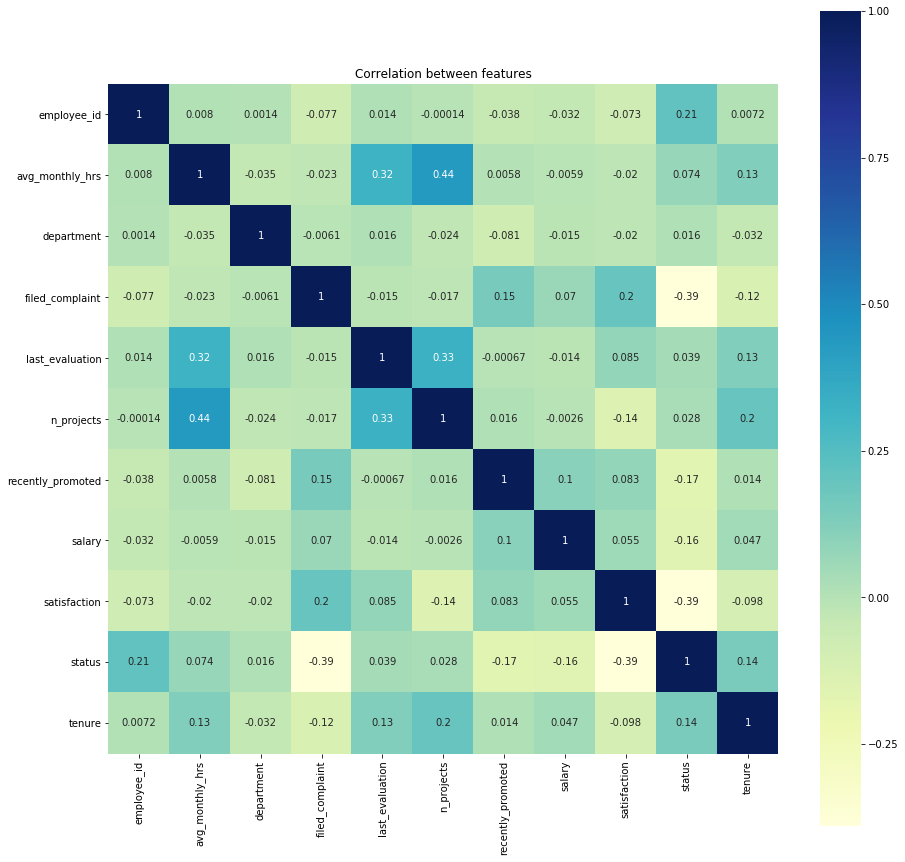

In [14]:
import matplotlib.pyplot as plt 
import seaborn as sns
corr = data_df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, square = True, cmap='YlGnBu',linecolor ='black')
#sns.heatmap(corr,vmax=.8,linewidth=.01, square = True, annot = True,cmap='YlGnBu',linecolor ='black')
plt.title('Correlation between features')

In [15]:
data_df[data_df.columns[1:]].corr()['status'][:]

avg_monthly_hrs      0.074082
department           0.015586
filed_complaint     -0.390649
last_evaluation      0.039058
n_projects           0.027647
recently_promoted   -0.165977
salary              -0.156124
satisfaction        -0.386584
status               1.000000
tenure               0.142071
Name: status, dtype: float64

In [16]:
import pandas_profiling
import matplotlib.pyplot as plt                                     
import seaborn as sns
import pandas as pd 
import numpy as np
%matplotlib inline
sns.set()

from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import pickle

y = data_df['status']

#Configure X as other columns except Result

X = data_df.drop(['status'],1)

#Split the test and traning data as 80:20 ratio
#from sklearn.model_selection import train_test_split
X_train, X_test_1, y_train, y_test_1 = train_test_split(X, y, test_size=0.2,random_state=1)

X_test, X_cv, y_test, y_cv = train_test_split(X_test_1, y_test_1, test_size=0.25, random_state=1)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_cv.shape, y_cv.shape)
      

dump_df=pd.DataFrame()
dump_df['employee_id'] = X_test['employee_id']
dump_df['actual_status'] = y_test
dump_df = dump_df.reset_index(drop=True)

(11320, 10) (11320,)
(2122, 10) (2122,)
(708, 10) (708,)


In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def calculate_error(test, pred):
    """
    Calculate the accuracy, precision, recall and F-score for test and predict data
    """
    print('Accuracy score for test data is:', accuracy_score(test,pred))
    print(pd.DataFrame(confusion_matrix(test,pred,labels=[-1, 1]),index=['Actual:-1','Actual:1'],columns=['Pred:-1','Pred:1']))
    print(classification_report(test, pred))
    #print(np.count_nonzero(test==1), np.count_nonzero(test==-1))
    #print(np.count_nonzero(pred==1), np.count_nonzero(pred==-1))

In [18]:
#RF with best hyper parameters
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestClassifier()

param_grid = {
    'n_estimators':[10,50,100,200], 'min_samples_split':range(2,10,1), 'max_features':[0.5,0.8,0.9,'auto']}

n_iter_search = 20
search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, return_train_score=True,n_iter=n_iter_search, cv=5, n_jobs=-1)

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            

from time import time
start = time()
search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(search.cv_results_)

print("model Test score: %.3f" % search.score(X_test, y_test))
search.best_params_

RandomizedSearchCV took 90.54 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.979 (std: 0.004)
Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 0.5}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'n_estimators': 100, 'min_samples_split': 7, 'max_features': 0.5}

Model with rank: 3
Mean validation score: 0.979 (std: 0.003)
Parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_features': 0.8}

model Test score: 0.982


{'max_features': 0.5, 'min_samples_split': 2, 'n_estimators': 200}

In [19]:
clf = RandomForestClassifier(**search.best_params_)
clf.fit(X_train, y_train)

#test data set
y_pred = clf.predict(X_test)
#print("model score: %.3f" % clf.score(X_test, y_test))
calculate_error(y_test,y_pred)

Accuracy score for test data is: 0.9825636192271442
           Pred:-1  Pred:1
Actual:-1        0       0
Actual:1         0     473
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1621
           1       0.98      0.94      0.96       501

    accuracy                           0.98      2122
   macro avg       0.98      0.97      0.98      2122
weighted avg       0.98      0.98      0.98      2122



In [20]:
#CV dataset
y_pred = clf.predict(X_cv)
#print("model score: %.3f" % clf.score(X_test, y_test))
calculate_error(y_cv,y_pred)

Accuracy score for test data is: 0.9872881355932204
           Pred:-1  Pred:1
Actual:-1        0       0
Actual:1         0     144
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       557
           1       0.99      0.95      0.97       151

    accuracy                           0.99       708
   macro avg       0.99      0.98      0.98       708
weighted avg       0.99      0.99      0.99       708



In [21]:
clf = RandomForestClassifier(**search.best_params_)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_pred = clf.predict_proba(X_test)
result=pd.DataFrame(y_pred,columns=["left","employed"])
dump_df['RF_left_prob'] = result['left']
dump_df['RF_employed_prob'] = result['employed']
dump_df.head()

,employee_id,actual_status,RF_left_prob,RF_employed_prob
0,108441,0,1.000,0.000
1,114068,0,1.000,0.000
2,112979,0,1.000,0.000
3,128968,1,0.000,1.000
4,117373,0,0.995,0.005


In [0]:
dump_df.to_csv("/content/drive/My Drive/Colab Notebooks/INSIAD_GCD/result.csv")

In [23]:
final_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/INSIAD_GCD/GCD_Capstone_Project_unseen_data_cleanup.csv")
del final_df['Unnamed: 0']
final_df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,tenure,employee_id
0,134,0,0,0.528841,2,0,1,0.400464,3,119045
1,221,1,1,0.784561,2,0,1,0.759513,3,112223
2,156,2,1,0.545183,2,0,2,0.336457,3,103924
3,133,3,0,0.744114,4,1,2,0.832039,2,105922
4,135,2,1,0.454637,2,0,1,0.320723,5,103297


In [24]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
avg_monthly_hrs      100 non-null int64
department           100 non-null int64
filed_complaint      100 non-null int64
last_evaluation      100 non-null float64
n_projects           100 non-null int64
recently_promoted    100 non-null int64
salary               100 non-null int64
satisfaction         100 non-null float64
tenure               100 non-null int64
employee_id          100 non-null int64
dtypes: float64(2), int64(8)
memory usage: 7.9 KB


In [25]:
y_unseen = clf.predict_proba(final_df)

result_df=pd.DataFrame()
result_df['employee_id'] = final_df['employee_id']

result=pd.DataFrame(y_unseen,columns=["left","employed"])
result_df['RF_left_prob'] = result['left']
result_df['RF_employed_prob'] = result['employed']
result_df.head()

,employee_id,RF_left_prob,RF_employed_prob
0,119045,0.885,0.115
1,112223,0.885,0.115
2,103924,0.885,0.115
3,105922,0.885,0.115
4,103297,0.880,0.120


In [0]:
result_df.to_csv("/content/drive/My Drive/Colab Notebooks/INSIAD_GCD/result.csv")